In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [159]:
#other useful imports we've seen before

import h5py
import numpy as np
import math
import os

In [5]:
#import scipy.stats package 
import scipy.stats as stats

### Load up the trial-level neural data

In [6]:
#ok let's load the data mb
DATA_PATH = "/mnt/data3/yamins/visual/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH, mode='r')

In [7]:
#useful utility function for plotting HDF5 dimension labels
def dimnames(dataset):
    dims = dataset.dims  #get the dimension object
    dimlist = [x.label for x in dims.keys()]  #get the label attribute
    dimlist = map(str, dimlist)  #cast everything to string instead of "unicode" ... complicated rathole ... not strictly necessary
    return dimlist

In [8]:
Ventral_Dataset.keys()

[u'image_meta',
 u'images',
 u'neural_meta',
 u'time_averaged',
 u'time_averaged_trial_averaged',
 u'time_binned',
 u'time_binned_trial_averaged']

In [9]:
Ventral_Dataset['time_averaged']

<HDF5 group "/time_averaged" (3 members)>

In [10]:
Ventral_Dataset['time_averaged'].keys()

[u'variation_level_0', u'variation_level_3', u'variation_level_6']

In [11]:
Ventral_Dataset['time_averaged']['variation_level_0']

<HDF5 dataset "variation_level_0": shape (28, 640, 296), type "<f4">

In [12]:
dimnames(Ventral_Dataset['time_averaged']['variation_level_0'])

['trial', 'image', 'neuron']

### some remarks on reliability

In [17]:
#these are indices into the neurons dimension, defining different subsets of neurons
#in different brain areas
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS'][:]
print(V4_NEURONS)
print('\nThere are %d V4 neurons' % len(V4_NEURONS))

IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS'][:]
print(IT_NEURONS)
print('\n There are %d IT neurons' % len(IT_NEURONS))

[ 11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28
  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 163 164
 165 166 167 168 169 170 211 212 213 214 215 216 217 218 219 220 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295]

There are 128 V4 neurons
[  0   1   2   3   4   5   6   7   8   9  10  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 18

In [37]:
var_level = Ventral_Dataset['image_meta']['variation_level'][:]
unique_var_levels = np.unique(var_level)
unique_var_levels

array(['V0', 'V3', 'V6'], dtype='|S2')

In [38]:
#wrap the data into a useful bject for our purposes (reliability analysis)

IT_Data_by_trial = {}
for vl in unique_var_levels:
    level_number = int(vl[-1])
    arr = Ventral_Dataset['time_averaged']['variation_level_%s' % level_number][:, :, IT_NEURONS]
    IT_Data_by_trial[vl] = arr.swapaxes(0, 1)

In [19]:
#num_images by num_trials by num_neurons
IT_Data_by_trial['V6'].shape

(2560, 47, 168)

In [20]:
#here's a very simple implementation of split-half reliability

def get_correlation(data_by_trial, num_trials, num_splits):
    """arguments:
          data_by_trial -- (numpy array) the data
             assumes a tensor with structure is (stimuli, trials)
             
          num_trials -- (nonnegative integer) how many trials to consider
          
          num_splits (nonnegative integer) how many splits of the data to make
          
       returns:
          array of length num_splits
    """

    
    #get total number of trials
    num_total_trials = data_by_trial.shape[1]
    
    #you better not ask for more trials than you actually have
    assert num_trials <= num_total_trials, "You asked for %d trials but there's only %d" % (num_trials, num_total_trials)
    
    #we want to make sure that while we select groups of trials basically randomly,
    #that we can still exactly reproduce our results later
    #so to do this, we use a constructed random number generator to select trial groups
    #and seed the generator with seed = 0 (could be any non-negative integer, but the seed
    #*must* be set for this to be reproducible
    random_number_generator = np.random.RandomState(seed=0)

    corrvals = []
    for split_index in range(num_splits):
        #construct a new permutation of the trial indices
        perm =  random_number_generator.permutation(num_total_trials)
    
        #take the first num_trials/2 and second num_trials/2 pieces of the data
        first_half_of_trial_indices = perm[:int(num_trials / 2)]
        second_half_of_trial_indices = perm[int(num_trials / 2): num_trials]
        
        #mean over trial dimension
        mean_first_half_of_trials = data_by_trial[:, first_half_of_trial_indices].mean(axis=1)
        mean_second_half_of_trials = data_by_trial[:, second_half_of_trial_indices].mean(axis=1)
        
        #compute the correlation between the means
        corrval = stats.pearsonr(mean_first_half_of_trials, 
                                 mean_second_half_of_trials)[0]
        #add to the list
        corrvals.append(corrval)
        
    return np.array(corrvals)

(-1, 513)

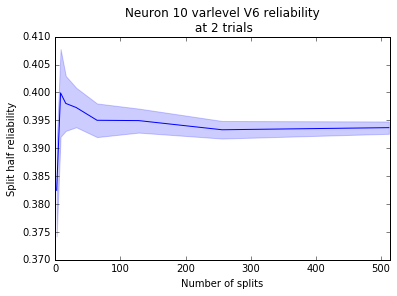

In [21]:
#in fact, let's plot reliability estimate and the SEM as a function of the number of splits
#... first for 10 trials

neuron_ind = 10
vl = 'V6'

num_trials = 2

means = []
sems = []

num_splits = [2, 8, 16, 32, 64, 128, 256, 512]
for ns in num_splits:
    cs = get_correlation(IT_Data_by_trial[vl][:, :, neuron_ind],
                           num_trials, 
                           ns)
    mean = cs.mean()
    means.append(mean)
    sem = cs.std() / np.sqrt(ns)
    sems.append(sem)
    
means = np.array(means)
sems = np.array(sems)

plt.plot(num_splits, means)
plt.fill_between(num_splits, means - sems, means + sems, color='b', alpha = 0.2)
plt.xlabel('Number of splits')
plt.ylabel('Split half reliability')
plt.title('Neuron %d varlevel %s reliability\n at %d trials' % (neuron_ind, vl, num_trials))
plt.xlim(-1, 513)

(-1, 513)

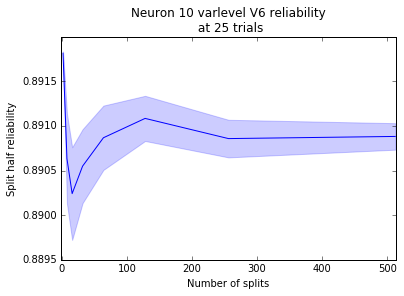

In [22]:
#... now for 25 trials
neuron_ind = 10
vl = b'V6'

num_trials = 25

means = []
sems = []

num_splits = [2, 8, 16, 32, 64, 128, 256, 512]
for ns in num_splits:
    cs = get_correlation(IT_Data_by_trial[vl][:, :, neuron_ind], 
                         num_trials, 
                         ns)
    mean = cs.mean()
    means.append(mean)
    sem = cs.std() / np.sqrt(ns)
    sems.append(sem)
    
means = np.array(means)
sems = np.array(sems)

plt.plot(num_splits, means)
plt.fill_between(num_splits, means - sems, means + sems, color='b', alpha = 0.2)
plt.xlabel('Number of splits')
plt.ylabel('Split half reliability')
plt.title('Neuron %d varlevel %s reliability\n at %d trials' % (neuron_ind, vl, num_trials))
plt.xlim(-1, 513)

#conclusion:  it looks like having num_splits ~ 10 * num_trials is good enough

In [23]:
#ok so now let's look at reliability as a function of number of trials

def get_reliability_curve(data):
    """
    This is a convenience function that plots reliability as a function of number of trials for some data
    
    arguments:
       data -- (numpy array) of shape (stimuli, trials)
    
    """
    means = []
    sems = []
    
    #determine the total number of trials
    total_num_trials = data.shape[1]
    
    #we'll evaluate reliability for each number of trials betwee 2 and the total
    num_trials = range(2, total_num_trials)
    for nt in num_trials:
        ns = 10 * nt
        cs = get_correlation(data,
                               nt, 
                               ns)
        mean = cs.mean()
        means.append(mean)
        sem = cs.std() / np.sqrt(ns)
        sems.append(sem)
        
        multiple = total_num_trials / float(nt) #have to do "float" here since python 2.x does integer division
         
    means = np.array(means)
    sems = np.array(sems)
    
    ln = plt.plot(num_trials, means)[0]  #this "ln" thing is a matplotlib thing -- usefor for making legens (see below)
    plt.fill_between(num_trials, means - sems, means + sems, color='b', alpha = 0.2)
 
    plt.xlabel('Number of Trials')
    plt.ylabel('Mean correlation')
    
    return ln

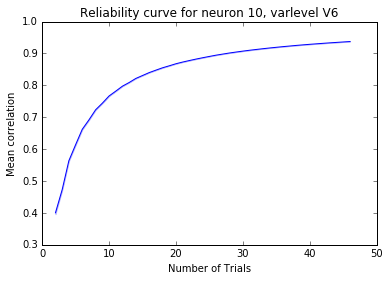

In [24]:
neuron_ind = 10
vl = b'V6'
get_reliability_curve(IT_Data_by_trial[vl][:, :, neuron_ind]);

ln = plt.title('Reliability curve for neuron %d, varlevel %s' % (neuron_ind, vl))




## Spearman Brown correction

In [25]:
def spearman_brown(uncorrected, multiple):
    numerator = multiple * uncorrected
    denominator = 1 + (multiple - 1) * uncorrected
    return numerator / denominator

In [26]:
#ok so now let's look at reliability as a function of number of trials

def get_reliability_curve_spearman_brown(data):
    """
    This is a convenience function that plots reliability as a function of number of trials for some data
    
    arguments:
       data -- (numpy array) of shape (stimuli, trials)
    
    """
    means = []
    sems = []
    corrected_means = []

    #determine the total number of trials
    total_num_trials = data.shape[1]
    
    #we'll evaluate reliability for each number of trials betwee 2 and the total
    num_trials = range(2, total_num_trials)
    for nt in num_trials:
        ns = 10 * nt
        cs = get_correlation(data,
                               nt, 
                               ns)
        mean = cs.mean()
        means.append(mean)
        sem = cs.std() / np.sqrt(ns)
        sems.append(sem)
        
        multiple = total_num_trials / float(nt) #have to do "float" here since python 2.x does integer division
        corrected_mean = spearman_brown(mean, multiple) 
        corrected_means.append(corrected_mean)
        
    means = np.array(means)
    sems = np.array(sems)
    corrected_means = np.array(corrected_means)
    
    ln = plt.plot(num_trials, means)[0]  #this "ln" thing is a matplotlib thing -- usefor for making legens (see below)
    plt.fill_between(num_trials, means - sems, means + sems, color='b', alpha = 0.2)
    
    ln_cor = plt.plot(num_trials, corrected_means)[0]

    plt.xlabel('Number of Trials')
    plt.ylabel('Mean correlation')
    
    return ln, ln_cor

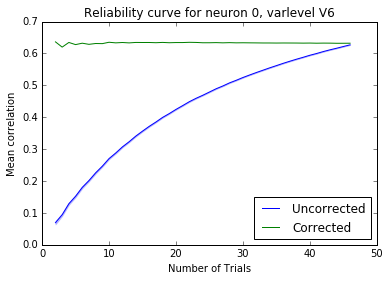

In [27]:
#ok the spearman-brown correction is a little bit of an overestimate here ...
#... but not bad
neuron_ind = 0
vl = b'V6'
ln, ln_cor = get_reliability_curve_spearman_brown(IT_Data_by_trial[vl][:, :, neuron_ind]);

plt.title('Reliability curve for neuron %d, varlevel %s' % (neuron_ind, vl))

plt.legend([ln, ln_cor], ['Uncorrected', 'Corrected'], loc='lower right')



## Correlation Analysis

In [317]:
#get the trial-averaged data
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
Neural_Data.shape

(5760, 296)

In [30]:
#we can create subsets of the neural data corresponding to different columns -- e.g. different groups of neurons
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
print('V4 neural data shape is %d images X %d V4 neurons' % V4_Neural_Data.shape)

IT_Neural_Data = Neural_Data[:, IT_NEURONS]
print('IT neural data shape is %d images X %d IT neurons' % IT_Neural_Data.shape)


V4 neural data shape is 5760 images X 128 V4 neurons
IT neural data shape is 5760 images X 168 IT neurons


In [31]:
categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

#now let's use what we just defined to create a dictionary whose keys are categories and whose values
#are arays of unique objects in each category
objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}

([<matplotlib.axis.YTick at 0x7fc6c1723a10>,
 <a list of 8 Text yticklabel objects>)

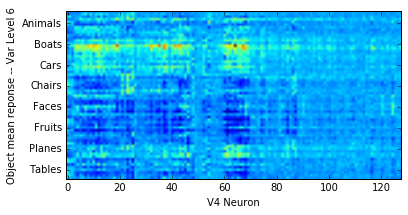

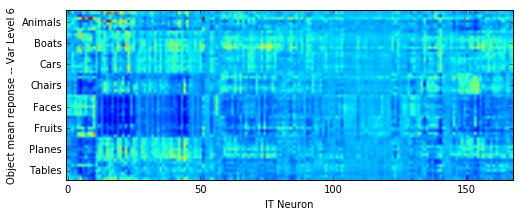

In [320]:
V4_object_means_by_category_var6 = np.row_stack([[V4_Neural_Data[(objects == o) & (var_level == 'V6')].mean(0) 
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])

IT_object_means_by_category_var6 = np.row_stack([[IT_Neural_Data[(objects == o) & (var_level == 'V6')].mean(0) 
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])




plt.imshow(V4_object_means_by_category_var6)
plt.xlabel('V4 Neuron')
plt.ylabel('Object mean reponse -- Var Level 6')
plt.yticks(np.arange(0, 64, 8)+4, unique_categories)
plt.figure(figsize=(8,5))
plt.imshow(IT_object_means_by_category_var6)
plt.xlabel('IT Neuron')
plt.ylabel('Object mean reponse -- Var Level 6')
plt.yticks(np.arange(0, 64, 8)+4, unique_categories)

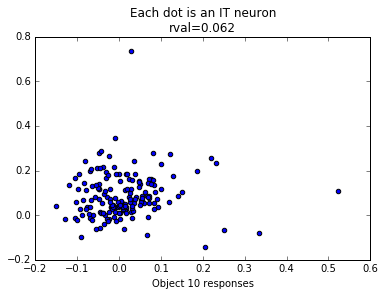

In [40]:
n1 = 0
n2 = 10
plt.scatter(IT_object_means_by_category_var6[n1], 
            IT_object_means_by_category_var6[n2])
plt.xlabel('Object %d responses' % n1)
plt.xlabel('Object %d responses' % n2)

rval = stats.pearsonr(IT_object_means_by_category_var6[n1], 
                     IT_object_means_by_category_var6[n2])[0]

plt.title('Each dot is an IT neuron\nrval=%.3f' % rval)

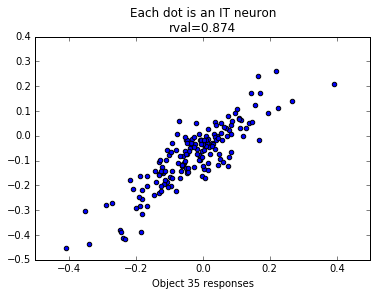

In [41]:
n1 = 32
n2 = 35
plt.scatter(IT_object_means_by_category_var6[n1], 
            IT_object_means_by_category_var6[n2])
plt.xlabel('Object %d responses' % n1)
plt.xlabel('Object %d responses' % n2)

rval = stats.pearsonr(IT_object_means_by_category_var6[n1], 
                     IT_object_means_by_category_var6[n2])[0]

plt.title('Each dot is an IT neuron\nrval=%.3f' % rval)

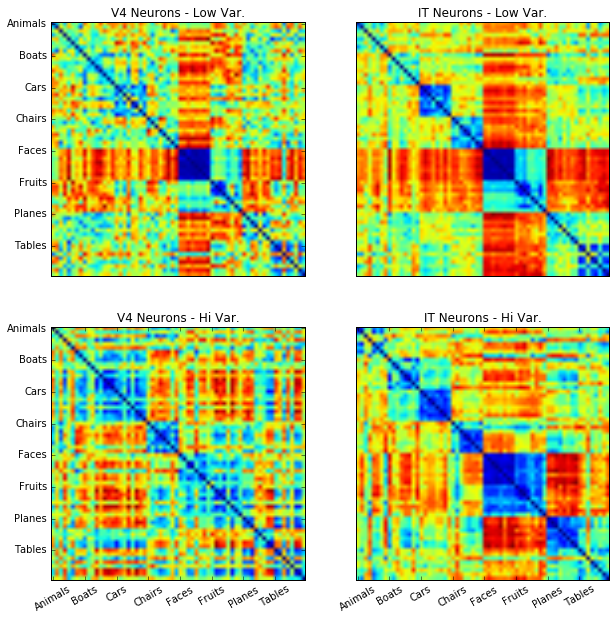

In [42]:
V4_object_means_by_category_var0 = np.row_stack([[V4_Neural_Data[(objects == o) & (var_level == 'V0')].mean(0) 
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])

IT_object_means_by_category_var0 = np.row_stack([[IT_Neural_Data[(objects == o) & (var_level == 'V0')].mean(0) 
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])


V4_rdm_var0 = 1 - np.corrcoef(V4_object_means_by_category_var0)
IT_rdm_var0  = 1 - np.corrcoef(IT_object_means_by_category_var0)

V4_rdm_var6 = 1 - np.corrcoef(V4_object_means_by_category_var6)
IT_rdm_var6  = 1 - np.corrcoef(IT_object_means_by_category_var6)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('V4 Neurons - Low Var.')
plt.imshow(V4_rdm_var0)
plt.yticks(np.arange(0, 64, 8), unique_categories); plt.xticks([]);
plt.subplot(2, 2, 2)
plt.title('IT Neurons - Low Var.')
plt.imshow(IT_rdm_var0)
plt.gca().set_xticks([]); plt.xticks([]); plt.yticks([]); plt.xticks([]);
plt.subplot(2, 2, 3)
plt.title('V4 Neurons - Hi Var.')
plt.imshow(V4_rdm_var6)
plt.yticks(np.arange(0, 64, 8), unique_categories); 
plt.xticks(np.arange(0, 64, 8), unique_categories, rotation=30);
plt.subplot(2, 2, 4)
plt.title('IT Neurons - Hi Var.')
plt.imshow(IT_rdm_var6)
plt.xticks(np.arange(0, 64, 8), unique_categories, rotation=30); plt.yticks([]);

In [43]:
#We'd like a control.   What about the images themselves?  After all, the 
#images are like a 256x256 = 65,536 dimensional representation. 

all_images = Ventral_Dataset['images']
all_images.dims.keys()

[<"image" dimension 0 of HDF5 dataset at 140492073054672>,
 <"height" dimension 1 of HDF5 dataset at 140492073054672>,
 <"width" dimension 2 of HDF5 dataset at 140492073054672>]

In [44]:
image_object_means_by_category_var0 = np.row_stack([[all_images[(objects == o) & (var_level == 'V0'), :, :].mean(0)
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])

image_object_means_by_category_var6 = np.row_stack([[all_images[(objects == o) & (var_level == 'V6'), :, :].mean(0)
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])

#see, these are arrays of shape (num_objects, height, width)
image_object_means_by_category_var6.shape

(64, 256, 256)

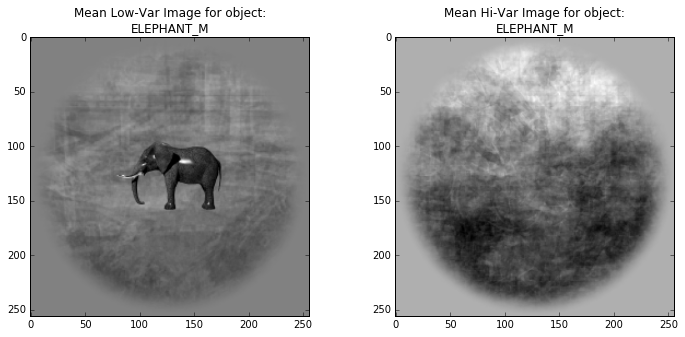

In [45]:
#just out of curiosity what do the mean images look like? 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_object_means_by_category_var0[0], cmap='gray')
plt.title('Mean Low-Var Image for object:\n%s' % objects_by_category['Animals'][0])

plt.subplot(1, 2, 2)
plt.imshow(image_object_means_by_category_var6[0], cmap='gray')
plt.title('Mean Hi-Var Image for object:\n%s' % objects_by_category['Animals'][0])

#so basically the pixel representation completely loses the object, on average, at high variation

In [46]:
#Gotta flatten out the two height width dimensions into 1:
image_object_means_by_category_var0_flat = image_object_means_by_category_var0.reshape((64, 256**2))
image_object_means_by_category_var6_flat = image_object_means_by_category_var6.reshape((64, 256**2))

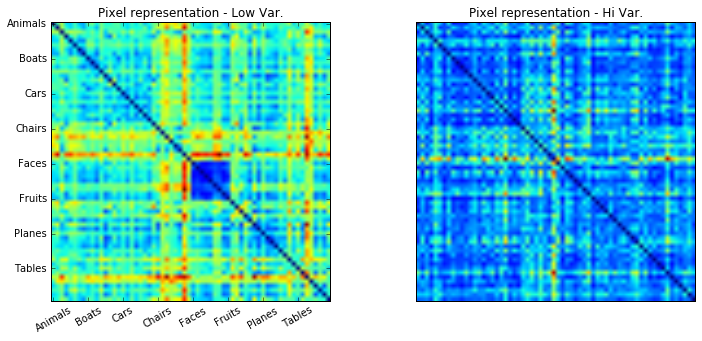

In [47]:
pixels_rdm_var0 = 1 - np.corrcoef(image_object_means_by_category_var0_flat)
pixels_rdm_var6 = 1 - np.corrcoef(image_object_means_by_category_var6_flat)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Pixel representation - Low Var.')
plt.imshow(pixels_rdm_var0)
plt.yticks(np.arange(0, 64, 8), unique_categories); 
plt.xticks(np.arange(0, 64, 8), unique_categories, rotation=30);

plt.subplot(1, 2, 2)
plt.title('Pixel representation - Hi Var.')
plt.imshow(pixels_rdm_var6)
plt.yticks([]); 
plt.xticks([]);

#interesting -- at low variation there is some structure -- especially, the faces stand out
#but at high variation basically everything is mush

### representation similarity analysis

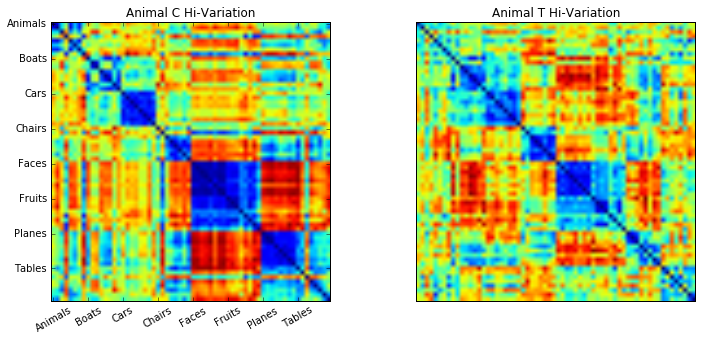

In [48]:
chabo = Ventral_Dataset['neural_meta']['ANIMAL_INFO'][:] == 'Chabo'
chabo_IT_NEURONS = IT_NEURONS[chabo[IT_NEURONS]]
chabo_IT_Neural_Data = Neural_Data[:, chabo_IT_NEURONS]

chabo_IT_object_means_by_category_var6 = np.row_stack([[chabo_IT_Neural_Data[(objects == o) & (var_level == 'V6')].mean(0) 
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])

tito = Ventral_Dataset['neural_meta']['ANIMAL_INFO'][:] == 'Tito'
tito_IT_NEURONS = IT_NEURONS[tito[IT_NEURONS]]
tito_IT_Neural_Data = Neural_Data[:, tito_IT_NEURONS]

tito_IT_object_means_by_category_var6 = np.row_stack([[tito_IT_Neural_Data[(objects == o) & (var_level == 'V6')].mean(0) 
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])

chabo_IT_rdm_var6  = 1 - np.corrcoef(chabo_IT_object_means_by_category_var6)
tito_IT_rdm_var6  = 1 - np.corrcoef(tito_IT_object_means_by_category_var6)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(chabo_IT_rdm_var6)
plt.title('Animal C Hi-Variation')
plt.yticks(np.arange(0, 64, 8), unique_categories); 
plt.xticks(np.arange(0, 64, 8), unique_categories, rotation=30);

plt.subplot(1, 2, 2)
plt.imshow(tito_IT_rdm_var6)
plt.title('Animal T Hi-Variation')
plt.yticks([]); plt.xticks([]); 

#similar between, but some notable differences -- Animal T seems "weaker" than Animal C!

In [49]:
#We need to take the upper right triangle (URT) of the RDMs for comparison purposes
from scipy.spatial.distance import squareform
V4_rdm_var0_flat = squareform(V4_rdm_var0, checks=False)
V4_rdm_var0_flat.shape
#see, the shape is 64 * 63 / 2 = 2016

V4_rdm_var6_flat = squareform(V4_rdm_var6, checks=False)
IT_rdm_var0_flat = squareform(IT_rdm_var0, checks=False)
IT_rdm_var6_flat = squareform(IT_rdm_var6, checks=False)
pixels_rdm_var0_flat = squareform(pixels_rdm_var0, checks=False)
pixels_rdm_var6_flat = squareform(pixels_rdm_var6, checks=False)

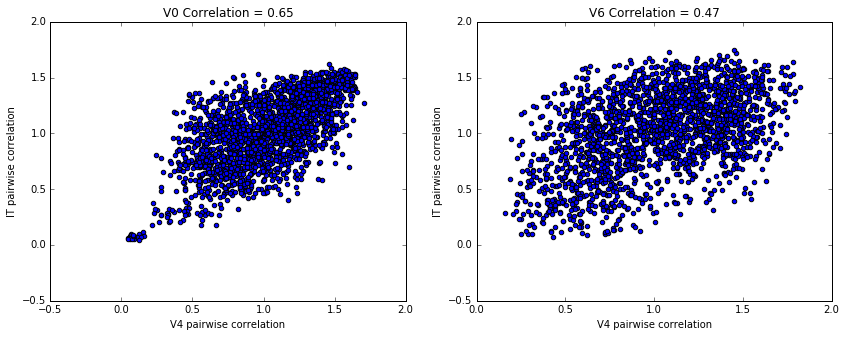

In [50]:
#now that we've got the URT, let's look at some comparisons, 
#first of IT vs V4 at low and high variation
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(V4_rdm_var0_flat, IT_rdm_var0_flat)
corrval_V0 = stats.pearsonr(V4_rdm_var0_flat, IT_rdm_var0_flat)[0]
plt.title('V0 Correlation = %.2f' % corrval_V0)
plt.xlabel('V4 pairwise correlation')
plt.ylabel('IT pairwise correlation')


plt.subplot(1, 2, 2)
plt.scatter(V4_rdm_var6_flat, IT_rdm_var6_flat)
corrval_V6 = stats.pearsonr(V4_rdm_var6_flat, IT_rdm_var6_flat)[0]
plt.title('V6 Correlation = %.2f' % corrval_V6)
plt.xlabel('V4 pairwise correlation')
plt.ylabel('IT pairwise correlation')

#if these numbers are to be believed, V4 and IT representations are more similar at low variation images
#than they are for high variation images. 

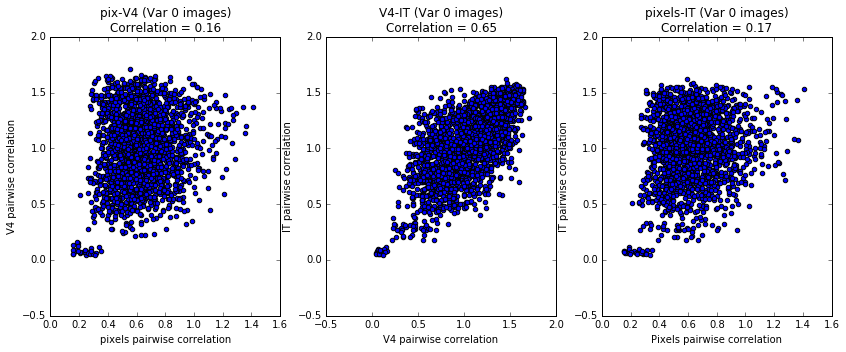

In [51]:
#now let's compare across pixels, V4 and IT 
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.scatter(pixels_rdm_var0_flat, V4_rdm_var0_flat)
corrval_pixV4 = stats.pearsonr(pixels_rdm_var0_flat, V4_rdm_var0_flat)[0]
plt.title('pix-V4 (Var 0 images)\nCorrelation = %.2f' % corrval_pixV4)
plt.xlabel('pixels pairwise correlation')
plt.ylabel('V4 pairwise correlation')

plt.subplot(1, 3, 2)
plt.scatter(V4_rdm_var0_flat, IT_rdm_var0_flat)
corrval_V4IT = stats.pearsonr(V4_rdm_var0_flat, IT_rdm_var0_flat)[0]
plt.title('V4-IT (Var 0 images)\nCorrelation = %.2f' % corrval_V4IT)
plt.xlabel('V4 pairwise correlation')
plt.ylabel('IT pairwise correlation')

plt.subplot(1, 3, 3)
plt.scatter(pixels_rdm_var0_flat, IT_rdm_var0_flat)
corrval_pixIT = stats.pearsonr(pixels_rdm_var0_flat, IT_rdm_var0_flat)[0]
plt.title('pixels-IT (Var 0 images)\nCorrelation = %.2f' % corrval_pixIT)
plt.xlabel('Pixels pairwise correlation')
plt.ylabel('IT pairwise correlation')

#V4 representation looks much closer to IT than either does to the pixels

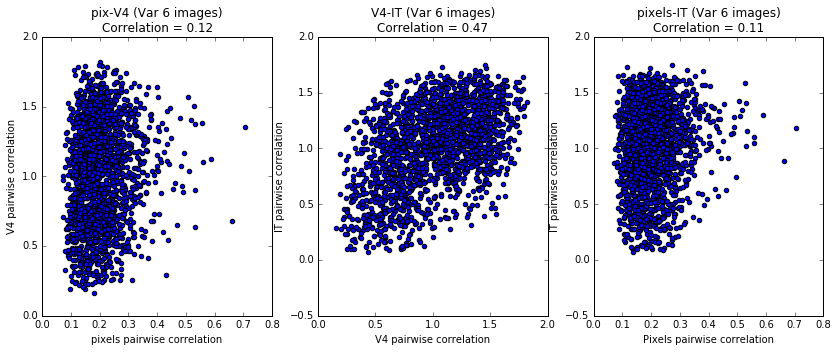

In [52]:
#And this result is especially true at high variation images
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.scatter(pixels_rdm_var6_flat, V4_rdm_var6_flat)
corrval_pixV4 = stats.pearsonr(pixels_rdm_var6_flat, V4_rdm_var6_flat)[0]
plt.title('pix-V4 (Var 6 images)\nCorrelation = %.2f' % corrval_pixV4)
plt.xlabel('pixels pairwise correlation')
plt.ylabel('V4 pairwise correlation')

plt.subplot(1, 3, 2)
plt.scatter(V4_rdm_var6_flat, IT_rdm_var6_flat)
corrval_V4IT = stats.pearsonr(V4_rdm_var6_flat, IT_rdm_var6_flat)[0]
plt.title('V4-IT (Var 6 images)\nCorrelation = %.2f' % corrval_V4IT)
plt.xlabel('V4 pairwise correlation')
plt.ylabel('IT pairwise correlation')

plt.subplot(1, 3, 3)
plt.scatter(pixels_rdm_var6_flat, IT_rdm_var6_flat)
corrval_pixIT = stats.pearsonr(pixels_rdm_var6_flat, IT_rdm_var6_flat)[0]
plt.title('pixels-IT (Var 6 images)\nCorrelation = %.2f' % corrval_pixIT)
plt.xlabel('Pixels pairwise correlation')
plt.ylabel('IT pairwise correlation')



Cross-Animal Correlation= 0.55


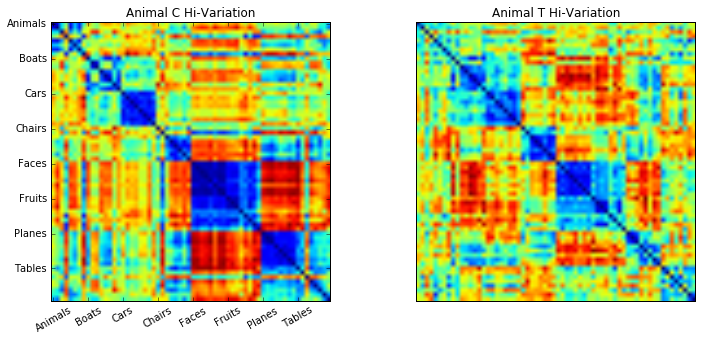

In [53]:
#but how close is V4 to IT? 
#well, actually let's compare to w/in animal controls

chabo = Ventral_Dataset['neural_meta']['ANIMAL_INFO'][:] == 'Chabo'
chabo_IT_NEURONS = IT_NEURONS[chabo[IT_NEURONS]]
chabo_IT_Neural_Data = Neural_Data[:, chabo_IT_NEURONS]

chabo_IT_object_means_by_category_var6 = np.row_stack([[chabo_IT_Neural_Data[(objects == o) & (var_level == 'V6')].mean(0) 
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])

tito = Ventral_Dataset['neural_meta']['ANIMAL_INFO'][:] == 'Tito'
tito_IT_NEURONS = IT_NEURONS[tito[IT_NEURONS]]
tito_IT_Neural_Data = Neural_Data[:, tito_IT_NEURONS]

tito_IT_object_means_by_category_var6 = np.row_stack([[tito_IT_Neural_Data[(objects == o) & (var_level == 'V6')].mean(0) 
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])

chabo_IT_rdm_var6  = 1 - np.corrcoef(chabo_IT_object_means_by_category_var6)
tito_IT_rdm_var6  = 1 - np.corrcoef(tito_IT_object_means_by_category_var6)

chabo_IT_rdm_var6_flat = squareform(chabo_IT_rdm_var6, checks=False)
tito_IT_rdm_var6_flat = squareform(tito_IT_rdm_var6, checks=False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(chabo_IT_rdm_var6)
plt.title('Animal C Hi-Variation')
plt.yticks(np.arange(0, 64, 8), unique_categories); 
plt.xticks(np.arange(0, 64, 8), unique_categories, rotation=30);

plt.subplot(1, 2, 2)
plt.imshow(tito_IT_rdm_var6)
plt.title('Animal T Hi-Variation')
plt.yticks([]); plt.xticks([]); 

#similar between, but some notable differences -- Animal T seems "weaker" than Animal C!

ct_corr = stats.pearsonr(chabo_IT_rdm_var6_flat, tito_IT_rdm_var6_flat)[0]
print('Cross-Animal Correlation= %.2f' % ct_corr)

In [54]:
#in fact, two animals' ITs are closer to each other -- but not by much than V4 overall is IT overall
#when pooled between the two animals.
ct_corr = stats.pearsonr(chabo_IT_rdm_var6_flat, tito_IT_rdm_var6_flat)[0]
print('Cross-Animal Correlation= %.2f' % ct_corr)

corrval_V4IT = stats.pearsonr(V4_rdm_var6_flat, IT_rdm_var6_flat)[0]
print('V4-IT correlation = %.2f' % corrval_V4IT)

Cross-Animal Correlation= 0.55
V4-IT correlation = 0.47


In [55]:
#lets dig into this a little more and look at both animals separated by V4 and IT
tito_V4_NEURONS = V4_NEURONS[tito[V4_NEURONS]]
chabo_V4_NEURONS = V4_NEURONS[chabo[V4_NEURONS]]
tito_V4_Neural_Data = Neural_Data[:, tito_V4_NEURONS]
chabo_V4_Neural_Data = Neural_Data[:, chabo_V4_NEURONS]

tito_V4_object_means_by_category_var6 = np.row_stack([[tito_V4_Neural_Data[(objects == o) & (var_level == 'V6')].mean(0) 
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])

chabo_V4_object_means_by_category_var6 = np.row_stack([[chabo_V4_Neural_Data[(objects == o) & (var_level == 'V6')].mean(0) 
                                                                for o in objects_by_category[c]]
                                                                for c in unique_categories])

chabo_V4_rdm_var6_flat  = squareform(1 - np.corrcoef(chabo_V4_object_means_by_category_var6), checks=False)
tito_V4_rdm_var6_flat  = squareform(1 - np.corrcoef(tito_V4_object_means_by_category_var6), checks=False)

In [56]:
#ok let's compute all the pairwise distances between areas per animal
#there are 4 animal-areas (two animals x two areas), so there are choose(4, 2) = 6 unique pairwise distances
chaboIT_titoIT_corr = stats.pearsonr(chabo_IT_rdm_var6_flat, tito_IT_rdm_var6_flat)[0]
chaboV4_titoV4_corr = stats.pearsonr(chabo_V4_rdm_var6_flat, tito_V4_rdm_var6_flat)[0]
chaboIT_titoV4_corr = stats.pearsonr(chabo_IT_rdm_var6_flat, tito_V4_rdm_var6_flat)[0]
chaboV4_titoIT_corr = stats.pearsonr(chabo_V4_rdm_var6_flat, tito_IT_rdm_var6_flat)[0]
chaboV4_chaboIT_corr = stats.pearsonr(chabo_IT_rdm_var6_flat, chabo_V4_rdm_var6_flat)[0]
titoV4_titoIT_corr = stats.pearsonr(tito_IT_rdm_var6_flat, tito_V4_rdm_var6_flat)[0]

print('Animal C IT / Animal T IT Correlation= %.2f' % chaboIT_titoIT_corr)
print('Animal C V4 / Animal T V4 Correlation= %.2f' % chaboV4_titoV4_corr)
print('Animal C IT / Animal T V4 Correlation= %.2f' % chaboIT_titoV4_corr)
print('Animal C V4 / Animal T IT Correlation= %.2f' % chaboV4_titoIT_corr)
print('Animal C V4 / Animal C IT Correlation= %.2f' % chaboV4_chaboIT_corr)
print('Animal T V4 / Animal T IT Correlation= %.2f' % titoV4_titoIT_corr)

#let's make a distance matrix of them in whatever order
#say ... titoV4 chaboV4 titoIT chaboIT
distmat = 1 - np.array([[1, chaboV4_titoV4_corr, titoV4_titoIT_corr, chaboIT_titoV4_corr],
                        [chaboV4_titoV4_corr, 1, chaboV4_titoIT_corr, chaboV4_chaboIT_corr],
                        [titoV4_titoIT_corr, chaboV4_titoIT_corr, 1, chaboIT_titoIT_corr],
                        [chaboIT_titoV4_corr, chaboV4_chaboIT_corr, chaboIT_titoIT_corr, 1]])

Animal C IT / Animal T IT Correlation= 0.55
Animal C V4 / Animal T V4 Correlation= 0.68
Animal C IT / Animal T V4 Correlation= 0.45
Animal C V4 / Animal T IT Correlation= 0.58
Animal C V4 / Animal C IT Correlation= 0.31
Animal T V4 / Animal T IT Correlation= 0.69


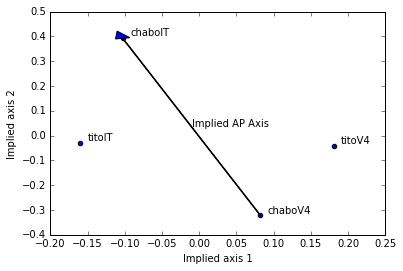

In [57]:
#Ok, let's visualize what we got.  Have 4 points (4 animal-areas) but really to 
#want to look at them in 2 dimensions.  How? Let's use multi-dimensional scaling

from sklearn.manifold import MDS
x, y = MDS(dissimilarity='precomputed').fit_transform(distmat).T
plt.scatter(x, y)
labels = ['titoV4', 'chaboV4', 'titoIT', 'chaboIT']
for i in range(4):
    plt.annotate(labels[i], (x[i], y[i]), (x[i]+.01, y[i]+.01))
plt.xlabel('Implied axis 1')
plt.ylabel('Implied axis 2')

plt.arrow(x[1], y[1], x[3] - x[1], y[3]-y[1])
plt.text(x[1] + (x[3] - x[1]) / 2, y[1] + (y[3] - y[1]) / 2, 'Implied AP Axis')

#Conclusion:  The "IT" arrays in animal T are probably more posterior than they are in animal C.  
#             (While the V4 arrays are pretty close between the two animals.)
#             So we can perhaps think of Animal C's IT array as the "truly" IT-like area.  
#background:  Yes, that can be seen to be true from surgerical notes. 

plt.savefig('tito_chabo.pdf')

## Single Neuron Correlations

In [58]:
"""
We're interested in correlations of neural data with potential behavioral outputs. 
So, for example, let's say wanted to use neurons to predict the horizontal position of the 
object in the image -- that is, the "translation_y" field of the image metadata. 
""";

In [59]:
#first let's load the y-position data
ypos = Ventral_Dataset['image_meta']['translation_y'][:] 

In [60]:
#Now, let's get the correlation between this metadata and neural responses
#for each neuron
corr_ypos = np.array([stats.pearsonr(Neural_Data[:, i], ypos)[0] 
                      for i in range(Neural_Data.shape[1])])

corr_ypos.shape
#right, there are 296 -- one for each neuron

(296,)

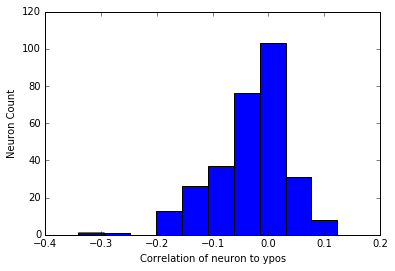

In [61]:
#let's see how good or bad our overall correlations are
plt.hist(corr_ypos)
plt.xlabel('Correlation of neuron to ypos')
plt.ylabel('Neuron Count')
#a few outliers, mostly not that great

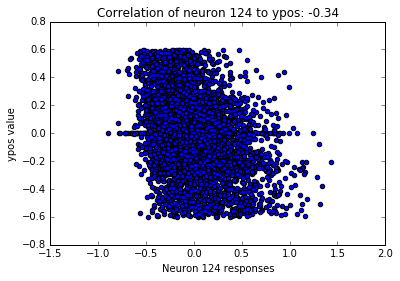

In [121]:
#let's visualize the correlation of the best neuron
abs_corr_ypos = np.abs(corr_ypos) #first, get the absolute corre/lations, since that's what matters
best_ind = abs_corr_ypos.argmax()   #now find the index of the most-absolute-correlated neuron
most_corred = Neural_Data[:, best_ind]       #get that neuron's responses
plt.scatter(most_corred, ypos)              #let's scatter-plot it against the true ypos values
plt.xlabel('Neuron %d responses' % best_ind)
plt.ylabel('ypos value')
plt.title('Correlation of neuron %d to ypos: %.2f' % (best_ind, corr_ypos[best_ind]))

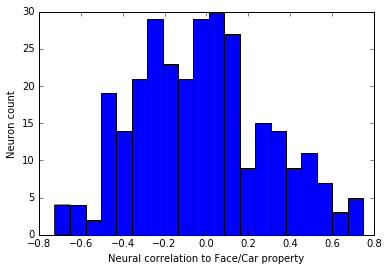

In [101]:
#Ok; we'll come back to these correlations later in the course. 
#for now, let's focus on relationships of category variables

#specifically, lets look at correlations bewteen neurons and
#the property of "Being a Face or Being a Car"
# .... at variation levels V0  (low) and V3 (medium)

#get per-stimulus arrays of category and variation level
category = Ventral_Dataset['image_meta']['category'][:]
var_level = Ventral_Dataset['image_meta']['variation_level'][:]

#subselect for being V0/V3 variation level and being a face or a car
v0v3 = ((var_level == 'V0') | (var_level == 'V3'))
face_or_car = ((category == 'Faces') | (category == 'Cars'))
subset_inds = v0v3 & face_or_car
Neural_Data_subset = Neural_Data[subset_inds]  #<-- neural responses just for V0/V3 car and face images
category_subset = (category[subset_inds] == 'Faces') #<-- boolean variable as to whether it's a car or a face

#now compute correlations between neuron responses and this output property
corr_face_vs_car = np.array([stats.pearsonr(Neural_Data_subset[:, i], category_subset)[0] 
                      for i in range(Neural_Data.shape[1])])

#let's plot our results
plt.hist(corr_face_vs_car, bins=20)
plt.xlabel('Neural correlation to Face/Car property')
plt.ylabel('Neuron count')

#hey -- some of the neurons are pretty highly correlated to this! 
#(though maybe not unexpected from face-neuron results of last time)

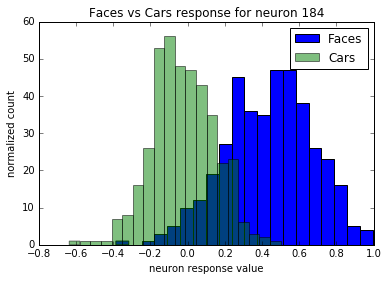

In [127]:
#Lets look at our results a bit more carefully

#find the most (absolutely) highly-correlated neuron
neurons_sorted_by_facevscar_abscorrelation = np.abs(corr_face_vs_car).argsort()
best_ind_facevscar = neurons_sorted_by_facevscar_abscorrelation[-1]

#this is a generic functio plotting distributions of responses
#for data two categories (a target and a "nottarget")
def hist_plot(resp, target_inds, target, nottarget):
    responses_on_target = resp[target_inds]
    responses_on_nottarget = resp[np.invert(target_inds)]
    l0 = plt.hist(responses_on_target, bins=20);
    l1 = plt.hist(responses_on_nottarget, bins=20, alpha=0.5);
    plt.legend([l0[2][0], l1[2][0]], [target, nottarget])
    plt.xlabel('neuron response value')
    plt.ylabel('normalized count')

most_corred_resp = Neural_Data_subset[:, best_ind_facevscar]
hist_plot(most_corred_resp, category_subset, 'Faces', 'Cars')
plt.title('Faces vs Cars response for neuron %d' % best_ind_facevscar)


In [128]:
most_corred_resp.shape

(800,)

In [129]:
#this is a generic function computing correctness for a
#prediction vs an actual.  This assumes the predictions are binary 
#(either 0  or 1)

def fraction_correct(predicted, actual):
    #get number of trials where predicted equals actual
    correct = (predicted == actual).sum()  
    #get total number of trials
    total = len(actual)
    #get fraction correct
    frac = correct / float(total)
    return frac

In [130]:
#So, if we made a binary judgement setting above a threshold ... 
threshold = .2
predicted_face = most_corred_resp > threshold

# ... we could compute a fraction correction
acc = fraction_correct(predicted_face, category_subset)
print('The percent correct is %.2f%%' % (acc * 100)) 

#setting the threshold at .2 is not bad

The percent correct is 87.38%


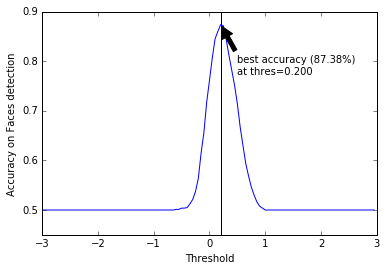

In [131]:
#let's look at performance as a function of threshold 

def plot_threshold_acc(resp, categories, target):
    threshold_series = np.arange(-3, 3, .05)
    pcs = [fraction_correct(resp > t, categories) 
                        for t in threshold_series]
    best_thres_ind = np.argmax(pcs)
    best_thres = threshold_series[best_thres_ind]
    best_acc = pcs[best_thres_ind]
    plt.plot(threshold_series, pcs)
    plt.axvline(best_thres, color='k')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy on %s detection' % target)
    plt.annotate('best accuracy (%.2f%%)\nat thres=%.3f' % (best_acc * 100, best_thres),
                 xy=(best_thres, best_acc), 
                 xytext=(best_thres + .3, best_acc - .1),
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
    
plot_threshold_acc(most_corred_resp, category_subset, 'Faces')
#in fact, .2 was the optimal threshold
#also, we can see chance is 50%

In [132]:
Neural_Data.shape

(5760, 296)

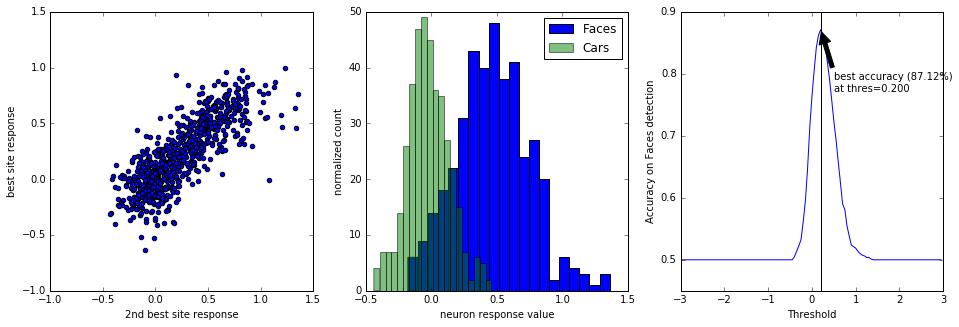

In [133]:
#how does the second best individual neuron at this Car/Face task look?
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
secondbest_ind_facevscar = neurons_sorted_by_facevscar_abscorrelation[-2]
secondmost_corred_resp = Neural_Data_subset[:, secondbest_ind_facevscar]
plt.scatter(secondmost_corred_resp, most_corred_resp)
plt.xlabel('2nd best site response')
plt.ylabel('best site response')

plt.subplot(1, 3, 2)
hist_plot(secondmost_corred_resp, category_subset, 'Faces', 'Cars')

plt.subplot(1, 3, 3)
plot_threshold_acc(secondmost_corred_resp, category_subset, 'Faces')

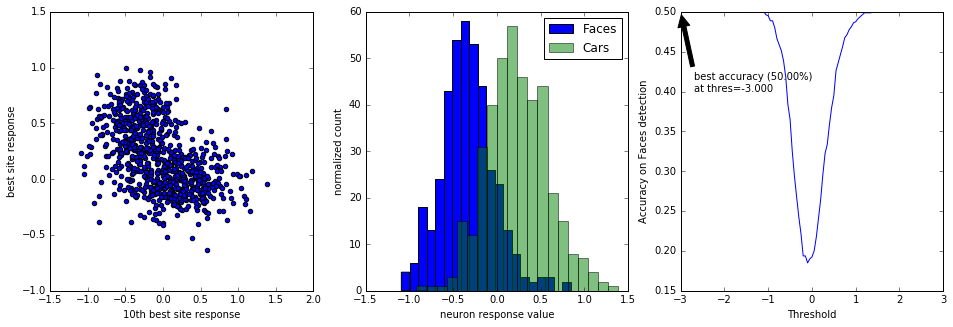

In [135]:
#what about the tenth best neuron?
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
tenthbest_ind = neurons_sorted_by_facevscar_abscorrelation[-10]
tenthmost_corred_resp = Neural_Data_subset[:, tenthbest_ind]
plt.scatter(tenthmost_corred_resp, most_corred_resp)
plt.xlabel('10th best site response')
plt.ylabel('best site response')

plt.subplot(1, 3, 2)
hist_plot(tenthmost_corred_resp, category_subset, 'Faces', 'Cars')

plt.subplot(1, 3, 3)
plot_threshold_acc(tenthmost_corred_resp, category_subset, 'Faces')

#ok weird -- we really need to multiple this guy by -1, since it's anti-correlated

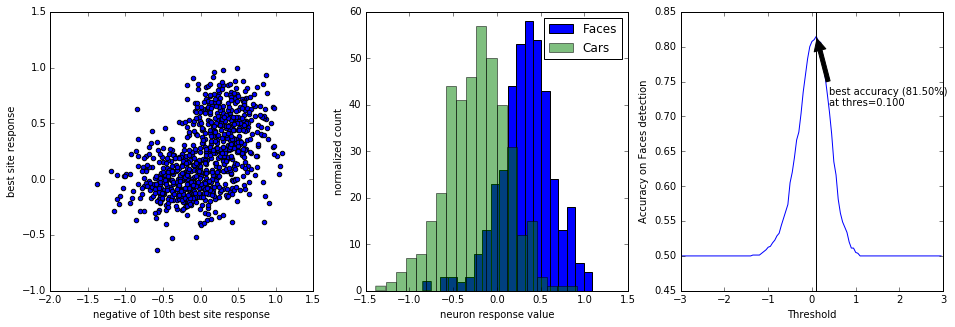

In [136]:
#ok now that we've multiplied by -1 things look more normal
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
tenthbest_ind = neurons_sorted_by_facevscar_abscorrelation[-10]
tenthmost_corred_resp = -Neural_Data_subset[:, tenthbest_ind]
plt.scatter(tenthmost_corred_resp, most_corred_resp)
plt.xlabel('negative of 10th best site response')
plt.ylabel('best site response')

plt.subplot(1, 3, 2)
hist_plot(tenthmost_corred_resp, category_subset, 'Faces', 'Cars')

plt.subplot(1, 3, 3)
plot_threshold_acc(tenthmost_corred_resp, category_subset, 'Faces')

#although obviously this neuron wants a different threshold and is slightly less good overall

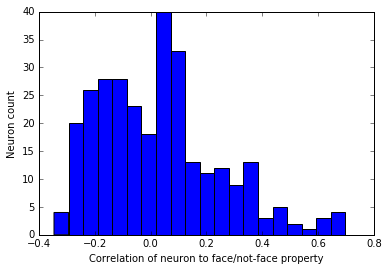

In [137]:
#let's broaden ourselves to looking at comparisons to more than just ... Cars

category = Ventral_Dataset['image_meta']['category'][:]
var_level = Ventral_Dataset['image_meta']['variation_level'][:]
v0v3_inds = ((var_level == 'V0') | (var_level == 'V3'))
Neural_Data_v0v3 = Neural_Data[v0v3_inds]  #now we're just subselected by variation, not by Cars/Faces only
category_v0v3 = category[v0v3_inds]
face_or_not_v0v3 = (category_v0v3 == 'Faces')

corr_facevsnot = np.array([stats.pearsonr(Neural_Data_v0v3[:, i], face_or_not_v0v3)[0] 
                      for i in range(Neural_Data_v0v3.shape[1])])
plt.hist(corr_facevsnot, bins=20)
plt.xlabel('Correlation of neuron to face/not-face property')
plt.ylabel('Neuron count')

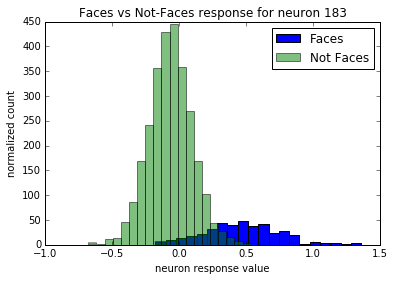

In [155]:
#Again, let's look at our best neuron

neurons_sorted_by_facevsnot_abscorrelation = np.abs(corr_facevsnot).argsort()
best_ind_facevsnot = neurons_sorted_by_facevsnot_abscorrelation[-1]
most_corred_resp_faceornot = Neural_Data_v0v3[:, best_ind_facevsnot]
hist_plot(most_corred_resp_faceornot, face_or_not_v0v3, 'Faces', 'Not Faces')
plt.title('Faces vs Not-Faces response for neuron %d' % best_ind_facevsnot)

#now the distribution is much more skewed obviously
#but the best neuron for the just is still the same actually

In [156]:
threshold = .2
predicted_face = most_corred_resp_faceornot > threshold
acc = fraction_correct(predicted_face, face_or_not_v0v3)
print('The percent correct is %.2f%%' % (acc * 100)) 

The percent correct is 93.34%


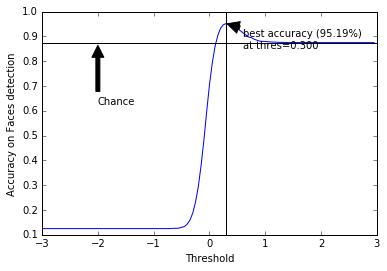

In [157]:
plot_threshold_acc(most_corred_resp_faceornot, face_or_not_v0v3, 'Faces')

plt.axhline(7/8., color='k')
plt.annotate('Chance', xy=(-2, 7/8.), xytext=(-2, 5/8.), arrowprops=dict(facecolor='black', shrink=0.05))
#hm -- couple of things
#  (1) the best threshold is no longer the middle between the means
#  (2) the level of chance is much higher now, so the raw performance is not that meaningful
#   ... see end of this notebook for detailed treatment of item (1)
#   ... item (2) will be solved in part by other metrics we'll look at in a bit

## Optimal binary threshold in the general case

In [144]:
def a_func(sig1, sig2):
    return (1. / (sig2**2)) - (1. / (sig1**2))

def b_func(mu1, sig1, mu2, sig2):
    return 2 * ((mu1 / sig1**2) - (mu2 / sig2**2))

def c_func(mu1, sig1, mu2, sig2, f):
    first_term = (mu2 / sig2)**2 - (mu1 / sig1)**2
    second_term = 2 * np.log((sig1 / sig2) * ((1-f) / f))
    return first_term - second_term

def get_optimal_threshold(mu1, sig1, mu2, sig2, f):
    a = a_func(sig1, sig2)
    b = b_func(mu1, sig1, mu2, sig2)
    c = c_func(mu1, sig1, mu2, sig2, f)
    numerator1 = -b + np.sqrt(b**2 - 4 * a * c)
    numerator2 = -b - np.sqrt(b**2 - 4 * a * c)
    denominator = 2 * a
    val1 = numerator1 / denominator
    val2 = numerator2 / denominator
    return val1, val2

In [153]:
mu1 = most_corred_resp_faceornot[face_or_not_v0v3].mean()
sig1 = most_corred_resp_faceornot[face_or_not_v0v3].std()
mu2 = most_corred_resp_faceornot[np.invert(face_or_not_v0v3)].mean()
sig2 = most_corred_resp_faceornot[np.invert(face_or_not_v0v3)].std()
f = face_or_not_v0v3.sum() / float(len(face_or_not_v0v3))
get_optimal_threshold(mu1, sig1, mu2, sig2, f)

(0.3053494445960652, -1.3698342605321248)